In [1]:
cd ../

/home/moomou/.pyenv/versions/3.10.13/envs/mlab4/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/moomou/dev/mono/research


In [2]:
import torch
import numpy as np
from pprint import pprint
import pathlib as pl
import torchaudio
import whisper
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import Audio

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import (
    LlamaTokenizer,
    MistralConfig,
    MistralForCausalLM,
)
import torch
from torch.utils.data import DataLoader
import pathlib as pl

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GenerationConfig

import torch
torch.backends.cuda.matmul.allow_tf32 = True

from src2.voixdb import util
from src2.voixdb.dataset.music_caps import (
    MusicCapsDataset,
    load_csv,
)
from src2.voixdb.model import Model, TunableWhisperAudioEncoder, load_llm
from src2.voixdb.train import Trainer
from src2.voixdb.train_cfg import TrainerCfg


In [150]:
# Access the values of the arguments
tr_cfg = TrainerCfg(
    epoch=1,
    model_save_freq=1,
    device="cuda:0",
    model_out_dir="/media/2nvme/proc/voixdb",
)

tokenizer, llm = load_llm()
audio_encoder = TunableWhisperAudioEncoder()

audio_encoder.to(tr_cfg.device)
model = Model(audio_encoder.to(torch.bfloat16), llm)

entries = load_csv()
train_size = int(len(entries) * 0.9)
train_entries = entries[:train_size]
eval_entries = entries[train_size:]

train_ds = MusicCapsDataset(train_entries, tokenizer, util.prompt_template_fn)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=12)

eval_ds = MusicCapsDataset(eval_entries, tokenizer, util.prompt_template_fn)
eval_dl = DataLoader(eval_ds, batch_size=1, shuffle=True, num_workers=6)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# verify model weight
from collections import Counter
pbytype = Counter()
for name, p in (model.named_parameters()):
    if torch.isinf(p).any() or torch.isnan(p).any():
        print(name, p)
        raise ValueError("invalid weight")
    else:
        pbytype[p.dtype] += 1
print("OK", pbytype)

OK Counter({torch.bfloat16: 489, torch.uint8: 224, torch.float16: 67})


In [ ]:
means = []
stds = []
norms = []
for name, p in (model.audio_encoder.audio_encoder.named_parameters()):
    if p.dim() == 2:
        print(p.dtype)
        print(p.max().item(), p.min().item())

        means.append(p.mean().item())
        stds.append(p.std().item())
        norms.append(torch.linalg.norm(p.to(torch.float).cpu().detach()))
        
plt.hist(means, bins=100, color='blue', alpha=0.7)

In [ ]:
norms = []
means = []
stds = []

for name, p in (model.audio_encoder.proj.named_parameters()):
    print(p.dtype)
    print(p.max().item(), p.min().item())
    means.append(p.mean().item())
    stds.append(p.std().item())
    norms.append(torch.linalg.norm(p.to(torch.float).cpu().detach()))

plt.hist(means, bins=100, color='red', alpha=0.7)

In [29]:
@torch.no_grad
def sampler(input_ids):
    outputs = []
    for _ in range(50):
        inputs_embeds = model.llm.model.embed_tokens(input_ids)
        res = model.llm(inputs_embeds=inputs_embeds)
        sampled = torch.multinomial(res.logits[:,-1,:].softmax(dim=-1), 1)# .to(device)
        input_ids = torch.cat((input_ids, sampled), dim=-1)
    return input_ids
        

In [99]:
tokenizer.decode(sampler(tokenizer("tell me a story", return_tensors="pt").input_ids.to(tr_cfg.device))[0])

'<s>tell me a story is a film and video production company, tell me a story is a concept that was created to allow people to come together through the power of storytelling.\n and so, with this massive power in storytelling, the founders and creat'

In [5]:
import torch.optim as optim

lr_default = 1.5e-3
adam_beta1 = 0.9
adama_beta2 = 0.999
adam_eps = 1e-8

# TODO: experiment with AdamW
optimizer = optim.Adam(
    model.parameters(),
    lr=lr_default,
    betas=(adam_beta1, adama_beta2),
    eps=adam_eps,
)
datagen = iter(train_dl)
device = tr_cfg.device
uds = []
losses = []
__registered_hook_refs = []

In [6]:
import torch
from functools import partial

for h in __registered_hook_refs:
    h.remove()

__global = []

def nan_hook(module, args, output, name=None):
    #if isinstance(module, bnb.nn.Linear8bitLt):
    if not isinstance(output, tuple):
        outputs = [output]
    else:
        outputs = output

    for i, out in enumerate(outputs):
        if out is None:
            continue
        if isinstance(out, tuple):
            for j, out2 in enumerate(out):
                nan_mask = torch.isnan(out2)
                if nan_mask.any():
                    __global.append((module, args, output))
                    raise RuntimeError(f"In module {name} of name {module.__class__.__name__}, Found NAN in output {j} at indices: ", nan_mask.nonzero(), "where:",
                               out[nan_mask.nonzero()[:, 0].unique(sorted=True)])
                # else:
                #    print((f"In module {name} of name {module.__class__.__name__}, Mean", out2.mean(), "std", out2.std()))
                               
        elif torch.is_tensor(out):
            nan_mask = torch.isnan(out)
            
            if nan_mask.any():
                __global.append((module, args, output))
                raise RuntimeError(f"In module {name} of name {module.__class__.__name__}, Found NAN in output {i} at indices: ", nan_mask.nonzero(), "where:",
                                   out[nan_mask.nonzero()[:, 0].unique(sorted=True)])
            # else:
            #    print((f"In module {name} of name {module.__class__.__name__}, Mean", out.mean(), "std", out.std()))

def register_nan_hook(model: torch.nn.Module):
    for name, submodule in model.named_modules():
        new_hook = partial(nan_hook, name=name+'.back')
        hook_ref = submodule.register_full_backward_hook(new_hook)
        __registered_hook_refs.append(hook_ref)
        new_hook = partial(nan_hook, name=name+'.fwd')
        hook_ref = submodule.register_forward_hook(new_hook)
        __registered_hook_refs.append(hook_ref)

debug = True
register_nan_hook(model) if debug else None

In [7]:
def fwd(self, batch):
    audio_mels = batch["audio_mels"]
    cap_ids = batch["cap_ids"]
    cap_ids_attention_mask = batch["cap_attention_mask"]
    prompt_ids = batch["prompt_ids"]
    prompt_ids_attention_mask = batch["prompt_attention_mask"]
    end_prompt_ids = batch["end_prompt_ids"]
    end_prompt_ids_attention_mask = batch["end_prompt_attention_mask"]

    audio_embeds = self.audio_encoder(audio_mels)
    # print('audio_embeds', audio_embeds.mean(dim=1), audio_embeds.std(dim=1))
    bs, audio_seq = audio_embeds.shape[:2]

    attention_mask = torch.concat(
        (
            prompt_ids_attention_mask,
            torch.ones(bs, audio_seq).to(cap_ids.device),
            end_prompt_ids_attention_mask,
            cap_ids_attention_mask,
        ),
        dim=1,
    )

    cap_embeds = self.llm.model.embed_tokens(cap_ids)
    prompt_embeds = self.llm.model.embed_tokens(prompt_ids)
    end_prompt_embeds = self.llm.model.embed_tokens(end_prompt_ids)
    inputs_embeds = torch.concat(
        (
            prompt_embeds,
            audio_embeds.to(cap_embeds.dtype),
            end_prompt_embeds,
            cap_embeds,
        ),
        dim=1,
    )

    # print('cap_embeds', cap_embeds.mean(dim=1), cap_embeds.std(dim=1))
    mout = self.llm(
        inputs_embeds=inputs_embeds,
        # output_attentions=True,
        # output_hidden_states=True,
        attention_mask=attention_mask,
        # use_cache=False,
    )

    return mout, audio_embeds.shape[1]

In [ ]:
# DEBUG compare audio embedding and txt embedding
# is audio embedding going to zero basically?

local_batch = next(iter(train_dl))

audio_file = local_batch["_id"][0][0]
audio_mels = load_audio_mels(audio_file).to(device).half()
prompt_ids, prompt_attention_mask = text_2_ids_and_attention_mask(
    tokenizer,
    prompt_template_fn(),
    )

prompt_ids = prompt_ids.to(device)
with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
    audio_embeds = model.audio_encoder(audio_mels)
    prompt_embeds = model.llm.model.embed_tokens(prompt_ids)



In [ ]:
for i in range(10):
    local_batch = next(datagen)
    # Transfer to GPU
    batch = {
        k: v.to(device)
        for k, v in local_batch.items()
        if not k.startswith("_")
    }
    # compute
    with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
        mout, audio_seq = fwd(model, batch)
    # calculate loss
    # local_batch: (b, seq, C)
    prompt_ids_seq = local_batch["prompt_ids"].shape[1]
    end_prompt_ids_seq = local_batch["end_prompt_ids"].shape[1]
    logits_start = prompt_ids_seq + audio_seq + end_prompt_ids_seq
    print("prompt_ids_seq", prompt_ids_seq)
    print("end_prompt_ids_seq", end_prompt_ids_seq)
    print("audio_seq", audio_seq)
    print("logits_start", logits_start)
    print("cap_ids.shape", local_batch["cap_ids"].shape)

    # remove the last output
    logits = mout.logits
    # remove the prompt and audio seq from logits
    # calculation; additionally, remove the final item
    logits = logits[:, logits_start:-1, :].contiguous()
    print(
         "logits.shape",
         mout.logits.shape,
         logits.shape,
         logits.view(-1, logits.shape[-1]).shape,
    )
    # calculate target using only `cap_ids`
    targets = batch["cap_ids"][:]
    targets = targets[:, 1:]
    print("target.shpae", targets.shape)
    print("target.reshape", targets.view(-1).shape)
    # print("logits", logits.view(-1, logits.shape[-1]).mean(dim=1), logits.view(-1, logits.shape[-1]).std(dim=1))
    
    loss = nn.functional.cross_entropy(
        logits.view(-1, logits.shape[-1]), targets.view(-1)
    )

    # required to access grad on non leaf nodes
    for p in model.audio_encoder.proj.parameters():
        if p.requires_grad:
            p.retain_grad()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        ud = []
        for p in model.audio_encoder.proj.parameters():
            if not p.requires_grad or p.grad is None:
                continue
            print(p.grad.mean(), p.grad.std())
            # print('p', 'grad', p.grad.std())
            ud.append(((lr_default*p.grad).std() / p.data.std()).log10().item())
        uds.append(ud)
        
    
    losses.append(loss.detach().cpu())
    print(f"{i}: {np.mean(losses):.4f}")


In [96]:
for _ in range(50):
    for i, local_batch in enumerate(train_dl):
        # local_batch = next(datagen)
        # Transfer to GPU
        batch = {
            k: v.to(device)
            for k, v in local_batch.items()
            if not k.startswith("_")
        }
        # compute
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            mout, audio_seq = fwd(model, batch)
        # calculate loss
        # local_batch: (b, seq, C)
        prompt_ids_seq = local_batch["prompt_ids"].shape[1]
        end_prompt_ids_seq = local_batch["end_prompt_ids"].shape[1]
        logits_start = prompt_ids_seq + audio_seq + end_prompt_ids_seq
        
        # remove the last output
        logits = mout.logits
        # remove the prompt and audio seq from logits
        # calculation; additionally, remove the final item
        logits = logits[:, logits_start:-1, :].contiguous()
        
        # calculate target using only `cap_ids`
        targets = batch["cap_ids"][:]
        targets = targets[:, 1:]
    
        # print("logits", logits.view(-1, logits.shape[-1]).mean(dim=1), logits.view(-1, logits.shape[-1]).std(dim=1))
        
        loss = nn.functional.cross_entropy(
            logits.view(-1, logits.shape[-1]), targets.view(-1)
        )
    
        # required to access grad on non leaf nodes
        for p in model.audio_encoder.proj.parameters():
            if p.requires_grad:
                p.retain_grad()
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            ud = []
            for name, p in model.audio_encoder.proj.named_parameters():
                if not p.requires_grad or p.grad is None:
                    continue
                # if i % 10 == 0:
                #    print(name, p.grad.mean().item(), p.grad.std().item())
                ud.append(((lr_default*p.grad).std() / p.data.std()).log10().item())
            uds.append(ud)
            
        
        losses.append(loss.detach().cpu())
        if i % 20 == 0:
            print(f"{i}: {np.mean(losses):.4f}")


0: 0.4192


KeyboardInterrupt: 

layer proj.weight | weight (4096, 1280) | mean +0.000000 | std 6.103516e-05 | grad:data ratio 6.752014e-04
layer ln1.weight | weight    (1280,) | mean -0.000001 | std 3.662109e-04 | grad:data ratio 4.736328e-02
layer ln1.bias | weight    (1280,) | mean +0.000026 | std 7.705688e-04 | grad:data ratio 7.995605e-03


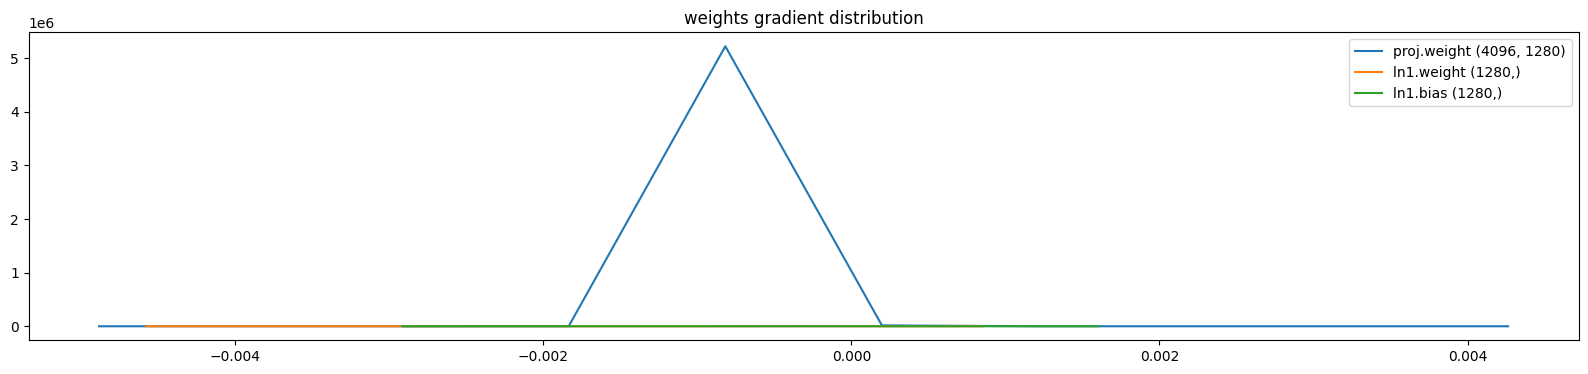

In [55]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
parameters = []
for i, l in enumerate([model.audio_encoder.proj]):
    #print('layer', l.__class__)
    for name, p in l.named_parameters():
        t = p.grad
        
        if t is None:
            continue

        print('layer %s | weight %10s | mean %+f | std %e | grad:data ratio %e' % (
            name, tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))

        hy, hx = np.histogram(t.to(torch.float32).cpu().detach().numpy())
        plt.plot(hx[:-1], hy)
        legends.append(f'{name} {tuple(p.shape)}')
            
plt.legend(legends)
plt.title('weights gradient distribution');

Text(0.5, 1.0, 'weight update relative to weight data, log scale')

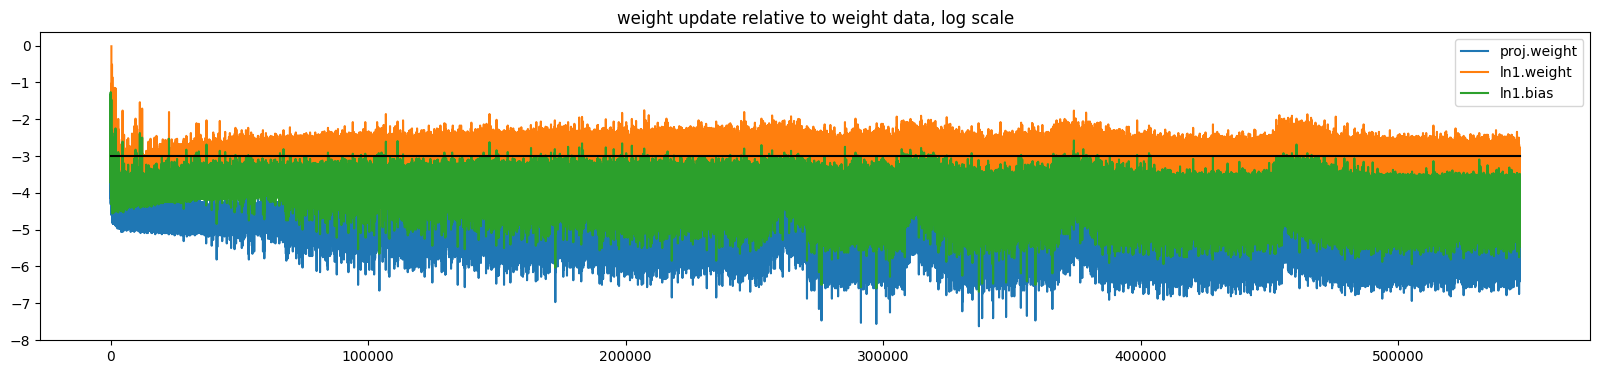

In [98]:
plt.figure(figsize=(20, 4))
legends = []
i = 0
for name, p in (model.audio_encoder.proj.named_parameters()):
    if p.grad is None:
        continue
    
    plt.plot([uds[epoch][i] for epoch in range(len(uds))])
    legends.append(name)

    i += 1
            
plt.plot([0, len(uds)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title("weight update relative to weight data, log scale")


In [142]:
l = torch.tensor(losses)

In [147]:
l[-50:].mean()

tensor(0.0640)

In [143]:
ml = l[:547200].reshape(-1, 100).mean(axis=1)

(0.0, 2.0)

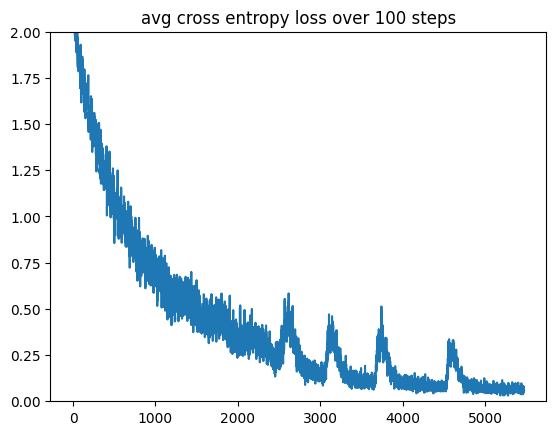

In [146]:
plt.plot(range((ml.shape[0])), ml.numpy())
plt.title("avg cross entropy loss over 100 steps")
plt.ylim(0, 2)

In [149]:
out = "/media/2nvme/proc/voixdb/model_manual_save3.pth"

torch.save(
    model.audio_encoder.proj.state_dict(),
    out,
)

In [88]:
datagen=iter(eval_dl)

In [90]:
local_batch = next(datagen)
audio_file = local_batch["_id"][0][0]
print(tokenizer.decode(local_batch["cap_ids"][0]))
Audio(audio_file)

This is a K-pop music piece performed by a boy band. Initially, a male vocalist is singing in a rap-like manner. Then, it switches to another male vocal that is singing more melodically. The melody is being played by a crisp synth sound. The rhythmic background consists of an energetic electronic drum beat. There is a danceable feel to it. This piece could be playing at Korean nightclubs and dance clubs.


In [151]:
tokenizer.decode(sample_with_audio(model, tokenizer, prompt_template_fn(), audio_file, iteration=60)[0])

'<s> <|im_start|>  system\n    You are a helpful AI who follows instruction carefully<|im_end|> <|im_start|>  user\n    Describe the sound of the given file \n    <|im_end|> <|im_start|>  assistant\n     war<|im_end|> clockunits ]andfirst4Iftektime爆R Cur<|im_end|> United<|im_end|> ’daysIn“Never<|im_end|> thenAnd,and VI<|im_end|> Islo<|im_end|> GOkaydown<|im_end|> JainteYoulfailedLabelsEvenfacevC,rest<|im_end|><|im_end|><|im_end|><|im_end|> q<|im_end|> Xs<|im_end|> h<|im_end|><|im_end|>'

In [68]:
import torch
import whisper

def prompt_template_fn(prompt="Describe the sound of the given file"):
    system_message = "You are a helpful AI who follows instruction carefully"

    prompt_prefix = f"""<|im_start|>system
    {system_message}<|im_end|>
    <|im_start|>user
    {prompt}"""

    return prompt_prefix


def end_template():
    return """
    <|im_end|>
    <|im_start|>assistant
    """


def load_audio_mels(file):
    audio = whisper.load_audio(file)
    audio = whisper.pad_or_trim(audio)
    audio_mels = whisper.log_mel_spectrogram(audio, n_mels=128)
    audio_mels = audio_mels.unsqueeze(0)
    return audio_mels


def text_2_ids_and_attention_mask(tokenizer, input_txt, truncate=False):
    txt = input_txt
    res = tokenizer(txt, return_tensors="pt")

    if truncate:
        return res.input_ids[:, 1:], res.attention_mask[:, 1:]

    return res.input_ids, res.attention_mask

@torch.no_grad()
def sample_with_audio(model, tokenizer, prompt, audio_file, device="cuda:0", iteration=50):
    audio_mels = load_audio_mels(audio_file).to(device).half()
    end_prompt_ids, end_prompt_attention_mask = text_2_ids_and_attention_mask(
        tokenizer,
        end_template(),
        truncate=True,
    )
    prompt_ids, prompt_attention_mask = text_2_ids_and_attention_mask(
        tokenizer,
        prompt,
    )

    prompt_ids = prompt_ids.to(device)
    prompt_attention_mask = prompt_attention_mask.to(device)
    end_prompt_attention_mask = end_prompt_attention_mask.to(device)
    end_prompt_ids = end_prompt_ids.to(device)
    sampled_ids = None

    prompt_embeds = None
    end_prompt_embeds = None
    audio_embeds = None

    with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
        if audio_embeds is None:
            audio_embeds = model.audio_encoder(audio_mels)
        bs, audio_seq = audio_embeds.shape[:2]
        
        mask_concat_args = [
            prompt_attention_mask,
            torch.ones(bs, audio_seq).to(audio_embeds.device),
            end_prompt_attention_mask,
        ]

        for _ in range(iteration):
            if sampled_ids is not None:
                mask_concat_args.append(torch.ones(bs, sampled_ids.shape[1]).to(audio_embeds.device))
                
            attention_mask = torch.concat(
                tuple(mask_concat_args),
                dim=1,
            )

            if prompt_embeds is None:
                prompt_embeds = model.llm.model.embed_tokens(prompt_ids)
            if end_prompt_embeds is None:
                end_prompt_embeds = model.llm.model.embed_tokens(end_prompt_ids)
                
            sampled_ids_embeds = None
            if sampled_ids is not None:
                sampled_ids_embeds = model.llm.model.embed_tokens(sampled_ids)
                
            embeds_concat_args = [
                prompt_embeds,
                audio_embeds.to(prompt_embeds.dtype),
                end_prompt_embeds,
            ]
            if sampled_ids_embeds is not None:
                embeds_concat_args.append(sampled_ids_embeds)
                
            inputs_embeds = torch.concat(
                tuple(embeds_concat_args),
                dim=1,
            )
    
            mout = model.llm(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
            )
    
            logits = mout.logits
            sampled = torch.multinomial(logits[:, -1, :].softmax(dim=-1), 1)
            
            if sampled_ids is None:
                sampled_ids = sampled
            else:
                sampled_ids = torch.cat((sampled_ids, sampled), dim=-1).to(device)

    # print(prompt_ids.shape)
    # print(end_prompt_ids.shape)
    # print(sampled_ids.shape)
    
    return torch.concat((
        prompt_ids, 
        end_prompt_ids,
        sampled_ids,
    ),dim=-1)
